> Mathematical Engineering and Physics using Machine Learning, EE798Z

##### *November 25th, 2024*

## Course Project - Wind Power Forecasting

**Kartik Anant Kulkarni (Roll no. 210493)**


----



# Phase 3 - Spatio-Temporal Wind Farm Output Modelling

## Settings
1. Please setup the environment as per the requirements with appropriate package versions.
2. As the notebook uses interactive widgets, to fully see and understand all the outputs, it is better to run the notebook before going through the outputs.

## Imports

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
from ipywidgets import interact, interact_manual, fixed
from typing import List, Iterable, Tuple, Dict, Optional, Callable

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor

from scipy.stats import entropy
from skopt import BayesSearchCV
from vmdpy import VMD
from xgboost import XGBRegressor

import tensorflow as tf
from dataclasses import dataclass
import pickle

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GRU, Dense, Flatten, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam

## Configuration

In [2]:
FONT_SIZE_TICKS = 15
FONT_SIZE_TITLE = 25
FONT_SIZE_AXES = 20

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
SDWPF_RAW_PATH = "./../Datasets/SDWPF_dataset/sdwpf_full/sdwpf_2001_2112_full.csv"
TURBINE_LOC_PATH = (
    "./../Datasets/SDWPF_dataset/sdwpf_full/sdwpf_turb_location_elevation.csv"
)
OPEN_WEATHER_FORECASTS = "./../Datasets/wind_speed_analysis/weather_forecast.pkl"
IMAGES_DIR = "./../output"

## Dataset

The raw dataset has the following time series features. The target variable is active power.
| Column Name | Specification Note |
| --- | --- |
| TurbID | Wind turbine ID |
| Tmstamp | Created time of the record Time zone UTC + 08:00 |
| Wspd (m/s) | The wind speed at the top of the turbine Recorded by mechanical anemometer |
| Wdir(°) | Relative wind direction, which is the angle between the wind direction and the the turbine nacelle direction. Wind  direction and nacelle direction are in degrees from true north |
| Etmp | Temperature of the surrounding environment Measured outer surface of the nacelle |
| Itmp | Temperature inside the turbine nacelle |
| Ndir (°) | Nacelle direction, the yaw angle of the nacelle In degree from true north |
| Pab1 (°) | Pitch angle of blade 1 The angle between the chord line and the rotation plane of the blade |
| Pab2 (°) | Pitch angle of blade 2 Same as above |
| Pab3 (°) | Pitch angle of blade 3 Same as above |
| Prtv (kW) | Reactive power |
| T2m | Temperature at 2 m above surface (ERA5) |
| Sp (Pa) | Surface pressure from ERA5 |
| RelH | Relative humidity Derived based on 2 m dew point temperature and 2m temperature using Python Package metpy |
| Wspd_w (m/s) | Wind speed from ERA5 At height of 10 m |
| Wdir_w (°) | Wind direction from ERA5 At height of 10 m |
| Tp (m) | Total precipitation from ERA5 |
| Patv (kW) | Active power, the wind power produced by a wind turbine |
<!-- | Day | Day of the record | -->

The new data also has the geolocations of each turbines with the elevations.

In [5]:
raw_data = pd.read_csv(SDWPF_RAW_PATH)
raw_data.head(5)

,TurbID,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
0,57,2020-01-03 04:25:00,7.935,0.055,2.185,23.415,236.59,-0.840,-0.840,-0.845,29.680,-12.312683,85893.516,0.529154,5.191925,52.389540,0.0,976.925
1,57,2020-01-03 04:55:00,6.425,-1.860,2.945,23.550,236.59,-0.610,-0.605,-0.610,14.480,-12.312683,85893.516,0.529154,5.191925,52.389540,0.0,610.830
2,57,2020-01-03 05:25:00,5.945,-1.635,3.720,23.350,236.59,-0.435,-0.435,-0.435,15.270,-11.709015,85836.430,0.516070,5.563238,56.420248,0.0,483.850
3,57,2020-01-03 05:55:00,6.290,1.220,4.385,23.285,236.59,-0.510,-0.510,-0.510,19.030,-11.709015,85836.430,0.516070,5.563238,56.420248,0.0,536.970
4,57,2020-01-03 06:25:00,5.650,3.790,4.945,23.265,243.84,-0.355,-0.355,-0.355,9.795,-10.475830,85820.766,0.515158,6.000677,55.780818,0.0,431.700


In [6]:
raw_data["Tmstamp"] = pd.to_datetime(raw_data["Tmstamp"])
raw_data.sort_values(by=["Tmstamp", "TurbID"], inplace=True)

# Backward fill missing values (NANs), i.e. the missing value is substituted with the next available value
raw_data = raw_data.bfill()
# For the rest of the values drop the corresponding entries
raw_data = raw_data.dropna()

print("Number of missing values per feature:\n")
print(raw_data.isnull().sum())

Number of missing values per feature:

TurbID     0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
T2m        0
Sp         0
RelH       0
Wspd_w     0
Wdir_w     0
Tp         0
Patv       0
dtype: int64


In [7]:
numerical_features = [
    f for f in list(raw_data.columns) if f not in ["TurbID", "Day", "Tmstamp"]
]
descriptive_stats = raw_data[numerical_features].describe()
descriptive_stats.apply(lambda s: s.apply("{0:.3f}".format))

,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
count,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000,11360922.000
mean,4.937,1.154,27.668,24.475,168.231,27.037,27.024,27.021,-9.313,9.246,85431.534,0.336,4.877,165.715,0.000,360.687
std,3.486,32.809,64.349,19.276,170.842,39.071,39.057,39.056,63.059,13.746,637.330,0.183,2.452,108.270,0.000,434.937
min,0.000,-1075.040,-273.170,-273.170,-1083.700,-10.000,-10.000,-10.000,-734.880,-22.302,83845.830,0.025,0.037,0.008,0.000,-9.310
25%,2.110,-3.400,7.255,16.440,41.960,0.010,0.010,0.010,-21.660,-2.270,84930.400,0.191,3.152,71.553,0.000,-0.300
50%,4.140,-0.220,18.870,25.230,178.860,0.330,0.330,0.330,-0.300,10.100,85378.625,0.298,4.403,117.353,0.000,172.140
75%,7.010,3.350,30.010,34.830,303.100,85.310,85.250,85.270,0.000,20.953,85925.250,0.452,6.338,267.490,0.000,588.735
max,56.870,842.140,394.330,324.210,700.630,99.980,99.980,99.980,500.310,37.662,87489.220,0.988,16.113,359.984,0.002,1561.380


In [8]:
def top_n_turbines(
    raw_data: pd.core.frame.DataFrame, n: int
) -> pd.core.frame.DataFrame:
    """Keeps only the top n turbines that produced more energy on average.

    Args:
        raw_data (pd.core.frame.DataFrame): The full dataset.
        n (int): Desired number of turbines to keep.

    Returns:
        pd.core.frame.DataFrame: The dataset with only the data from the top n turbines.
    """
    sorted_patv_by_turbine = (
        raw_data.groupby("TurbID")
        .mean(numeric_only=True)["Patv"]
        .sort_values(ascending=False)
    )
    top_turbines = list(sorted_patv_by_turbine.index)[:n]
    print(
        f"Original data has {len(raw_data)} rows from {len(raw_data.TurbID.unique())} turbines.\n"
    )
    raw_data = raw_data[raw_data["TurbID"].isin(top_turbines)]
    print(
        f"Sliced data has {len(raw_data)} rows from {len(raw_data.TurbID.unique())} turbines."
    )
    return raw_data


top_turbines = top_n_turbines(raw_data, 10)

Original data has 11360922 rows from 134 turbines.

Sliced data has 847830 rows from 10 turbines.


In [9]:
def plot_time_series(df: pd.core.frame.DataFrame, features: List[str]):
    """Creates interactive plots for the time series in the dataset.

    Args:
        df (pd.core.frame.DataFrame): The data used.
        features (List[str]): Features to include in the plot.
    """

    def plot_time_series(turbine, feature, date_range, fix_temps):
        data = df[df.TurbID == turbine]
        if fix_temps:
            min_etemp = data["Etmp"].quantile(0.01)
            data["Etmp"] = data["Etmp"].apply(lambda x: np.nan if x < min_etemp else x)
            data["Etmp"] = data["Etmp"].interpolate()
            min_itemp = data["Itmp"].quantile(0.01)
            data["Itmp"] = data["Itmp"].apply(lambda x: np.nan if x < min_itemp else x)
            data["Itmp"] = data["Itmp"].interpolate()

        data = data[data.Tmstamp > date_range[0]]
        data = data[data.Tmstamp < date_range[1]]
        plt.figure(figsize=(15, 5))
        plt.plot(data["Tmstamp"], data[feature], "-")
        plt.title(f"Time series of {feature}", fontsize=FONT_SIZE_TITLE)
        plt.ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        plt.xlabel(f"Date", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.show()

    turbine_selection = widgets.Dropdown(
        options=df.TurbID.unique(),
        value=df.TurbID.unique()[-1],
        description="Turbine ID",
    )

    feature_selection = widgets.Dropdown(
        options=features,
        description="Feature",
    )

    start_date = pd.to_datetime("2020-05-01")
    end_date = pd.to_datetime("2020-12-31")

    dates = pd.date_range(start_date, end_date, freq="D")

    options = [(date.strftime("%b %d"), date) for date in dates]
    index = (0, len(options) - 1)

    date_slider_selection = widgets.SelectionRangeSlider(
        options=options,
        index=index,
        description="Date (2020)",
        orientation="horizontal",
        layout={"width": "550px"},
    )

    fix_temps_button = widgets.Checkbox(
        value=False, description="Fix Temperatures", disabled=False
    )

    interact(
        plot_time_series,
        turbine=turbine_selection,
        feature=feature_selection,
        date_range=date_slider_selection,
        fix_temps=fix_temps_button,
    )


plot_time_series(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Turbine ID', index=9, options=(1, 3, 5, 6, 8, 9, 10, 11, 12, 26), …

In [10]:
def tag_abnormal_values(
    df: pd.core.frame.DataFrame, condition: pd.core.series.Series
) -> pd.core.frame.DataFrame:
    """Determines if a given record is an abnormal value.

    Args:
        df (pd.core.frame.DataFrame): The dataset used.
        condition (pd.core.series.Series): Series that includes if a record meets one of the conditions for being an abnormal value.

    Returns:
        pd.core.frame.DataFrame: Dataset with tagger abnormal values.
    """
    indexes = df[condition].index
    df.loc[indexes, "Include"] = False
    return df

In [11]:
# Initially include all rows
raw_data["Include"] = True

# Define conditions for abnormality
conditions = [
    np.isnan(raw_data.Patv),
    (raw_data.Pab1 > 89) | (raw_data.Pab2 > 89) | (raw_data.Pab3 > 89),
    (raw_data.Ndir < -720) | (raw_data.Ndir > 720),
    (raw_data.Wdir < -180) | (raw_data.Wdir > 180),
    (raw_data.Patv <= 0) & (raw_data.Wspd > 2.5),
]

# Exclude abnormal features
for condition in conditions:
    raw_data = tag_abnormal_values(raw_data, condition)

clean_data = raw_data[raw_data.Include].drop(["Include"], axis=1)
clean_data.head()

,TurbID,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
3077392,1,2020-01-01 00:10:00,10.44,-0.45,2.05,19.81,375.16,1.01,1.01,1.01,9.1,-11.705597,85489.42,0.505227,6.280565,83.357327,0.0,1503.05
3093504,2,2020-01-01 00:10:00,10.44,-0.45,2.05,19.81,375.16,1.01,1.01,1.01,9.1,-11.705597,85489.42,0.505227,6.280565,83.357327,0.0,1503.05
3109616,3,2020-01-01 00:10:00,10.44,-0.45,2.05,19.81,375.16,1.01,1.01,1.01,9.1,-11.705597,85489.42,0.505227,6.280565,83.357327,0.0,1503.05
3125728,4,2020-01-01 00:10:00,10.44,-0.45,2.05,19.81,375.16,1.01,1.01,1.01,9.1,-11.705597,85489.42,0.505227,6.280565,83.357327,0.0,1503.05
3141840,5,2020-01-01 00:10:00,10.44,-0.45,2.05,19.81,375.16,1.01,1.01,1.01,9.1,-11.705597,85489.42,0.505227,6.280565,83.357327,0.0,1503.05


### Feature Engineering

#### Blade Angles

Get rid of correlated Features Pab

In [12]:
def cut_pab_features(raw_data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Deletes redundant Pab features from dataset.

    Args:
        raw_data (pd.core.frame.DataFrame): The dataset used.

    Returns:
        pd.core.frame.DataFrame: The dataset without the redundant Pab features.
    """

    raw_data = raw_data.drop(["Pab2", "Pab3"], axis=1)
    raw_data = raw_data.rename(columns={"Pab1": "Pab"})

    return raw_data


clean_data = cut_pab_features(clean_data)

#### Angle Unit Change

There are 3 features (`Wdir`, `Ndir`, `Pab`) which are encoded in degrees. This is problematic because the model has no way of knowing that angles with very different values (such as 0° and 360°) are actually very similar (the same in this case) to each other. Thus transform them into `sine`/`cosine` representations.

In [13]:
def transform_angles(
    data: pd.core.frame.DataFrame, feature: str, drop_original: bool = True
):
    """Transform angles into their Sin/Cos encoding.

    Args:
        data (pd.core.frame.DataFrame): The dataset used.
        feature (str): Name of the angle feature.
        drop_original (bool, optional): Wheter to drop the original column from the dataset. Defaults to True.
    """
    rads = data[feature] * np.pi / 180

    data[f"{feature}Cos"] = np.cos(rads)
    data[f"{feature}Sin"] = np.sin(rads)

    if drop_original:
        data.drop(feature, axis=1, inplace=True)


for feature in ["Wdir_w", "Wdir", "Ndir", "Pab"]:
    transform_angles(clean_data, feature)

#### Temperature and Active Power

Both `Etmp` and `Itmp` have really negative values. In fact, these minimum values are very close to the absolute zero (-273.15 °C) which is most certainly an error. Use linear interpolation for the same.

Active power has negative values which doesn't make sense in the context of the problem at hand. The paper also addresses this issue by mentioning that all negative values should be treated as zero. 

In [14]:
def fix_temperatures(data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Replaces very low temperature values with linear interpolation.

    Args:
        data (pd.core.frame.DataFrame): The dataset.

    Returns:
        pd.core.frame.DataFrame: Dataset with fixed temperatures.
    """
    min_etemp = data["Etmp"].quantile(0.01)
    data["Etmp"] = data["Etmp"].apply(lambda x: np.nan if x < min_etemp else x)
    data["Etmp"] = data["Etmp"].interpolate()
    min_itemp = data["Itmp"].quantile(0.01)
    data["Itmp"] = data["Itmp"].apply(lambda x: np.nan if x < min_itemp else x)
    data["Itmp"] = data["Itmp"].interpolate()

    return data


clean_data = fix_temperatures(clean_data)
clean_data["Patv"] = clean_data["Patv"].apply(lambda x: max(0, x))

#### TOD Features

In [15]:
def generate_time_signals(raw_data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Creates time signal features (time-of-day) for the data.

    Args:
        raw_data (pd.core.frame.DataFrame): The dataset uded.

    Returns:
        pd.core.frame.DataFrame: The dataset with the new features.
    """
    if "Day sin" in raw_data.columns:
        return raw_data

    date_time = pd.to_datetime(raw_data.Tmstamp, format="%Y-%m-%d %H:%M")
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    day = 24 * 60 * 60

    raw_data["Time-of-day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
    raw_data["Time-of-day cos"] = np.cos(timestamp_s * (2 * np.pi / day))

    return raw_data


clean_data = generate_time_signals(clean_data)

In [16]:
clean_data

,TurbID,Tmstamp,Wspd,Etmp,Itmp,Prtv,T2m,Sp,RelH,Wspd_w,...,Wdir_wCos,Wdir_wSin,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin,Time-of-day sin,Time-of-day cos
3077392,1,2020-01-01 00:10:00,10.44,2.05,19.81,9.10,-11.705597,85489.42,0.505227,6.280565,...,0.115677,0.993287,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048
3093504,2,2020-01-01 00:10:00,10.44,2.05,19.81,9.10,-11.705597,85489.42,0.505227,6.280565,...,0.115677,0.993287,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048
3109616,3,2020-01-01 00:10:00,10.44,2.05,19.81,9.10,-11.705597,85489.42,0.505227,6.280565,...,0.115677,0.993287,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048
3125728,4,2020-01-01 00:10:00,10.44,2.05,19.81,9.10,-11.705597,85489.42,0.505227,6.280565,...,0.115677,0.993287,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048
3141840,5,2020-01-01 00:10:00,10.44,2.05,19.81,9.10,-11.705597,85489.42,0.505227,6.280565,...,0.115677,0.993287,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11203504,120,2021-12-31 23:50:00,2.46,1.55,10.56,-35.17,-12.468079,86241.92,0.577978,2.974639,...,0.999980,-0.006366,0.998763,0.049721,-0.939752,0.341856,1.000000,0.000175,-0.043619,0.999048
11256065,121,2021-12-31 23:50:00,2.26,-1.51,7.38,-44.18,-12.468079,86241.92,0.577978,2.974639,...,0.999980,-0.006366,0.998565,0.053556,0.834175,-0.551500,1.000000,0.000175,-0.043619,0.999048
11308626,122,2021-12-31 23:50:00,1.87,-1.11,7.60,-0.32,-12.468079,86241.92,0.577978,2.974639,...,0.999980,-0.006366,0.999180,0.040481,-0.249197,-0.968453,0.742093,0.670297,-0.043619,0.999048
10520211,129,2021-12-31 23:50:00,2.45,1.50,5.21,-0.30,-12.468079,86241.92,0.577978,2.974639,...,0.999980,-0.006366,0.960585,0.277985,0.601397,-0.798951,0.120483,0.992715,-0.043619,0.999048


### Resample - Hourly, 18 Turbines

Chosen Turboines: 120,121,122,95,96,110,84,85,86,16,17,18,28,29,30,65,66,67

In [17]:
def prepare_data(df: pd.core.frame.DataFrame, turb_id: int) -> pd.core.frame.DataFrame:
    """Pre-process data before feeding to neural networks for training.
    This includes:
    - Resampling to an hourly basis
    - Using data from a single turbine
    - Format datetime
    - Mask abnormal values
    - Re-order columns

    Args:
        df (pandas.core.frame.DataFrame): The curated data from the previous lab.
        turb_id (int): ID of the turbine to use.

    Returns:
        pandas.core.frame.DataFrame: Processed dataframe.
    """
    df = df[5::6]
    # df = df[df.TurbID == turb_id]
    # df = df.drop(["TurbID"], axis=1)
    # df.set_index("Tmstamp", inplace=True)
    # # Ensure the index covers all the expected timestamps (for example, hourly)
    # full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="h")

    # # Reindex the DataFrame to the full range of timestamps, filling missing data with NaN
    # df = df.reindex(full_time_range)

    # # Handle missing values before resampling:
    # # Fill missing values with forward fill or any other method (e.g., zero, interpolation)
    # df = df.ffill()  # Forward-fill NaNs
    # df = df.resample("h").mean()
    # assert df.isnull().sum().sum() == 0
    df.index = pd.to_datetime(df.pop("Tmstamp"), format="%Y-%m-%d %H:%M")

    df = df[
        [
            "Wspd",
            "Etmp",
            "Itmp",
            "Prtv",
            "T2m",
            "Sp",
            "RelH",
            "Wspd_w",
            "Tp",
            "WdirCos",
            "WdirSin",
            "NdirCos",
            "NdirSin",
            "PabCos",
            "PabSin",
            "Time-of-day sin",
            "Time-of-day cos",
            "Wdir_wCos",
            "Wdir_wSin",
            "Patv",
        ]
    ]

    return df


turb_id = 6
data = prepare_data(clean_data, turb_id)
data.head(5)

,Wspd,Etmp,Itmp,Prtv,T2m,Sp,RelH,Wspd_w,Tp,WdirCos,WdirSin,NdirCos,NdirSin,PabCos,PabSin,Time-of-day sin,Time-of-day cos,Wdir_wCos,Wdir_wSin,Patv
Tmstamp,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,10.44,2.05,19.81,9.1,-11.705597,85489.42,0.505227,6.280565,0.0,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048,0.115677,0.993287,1503.05
2020-01-01 00:10:00,10.44,2.05,19.81,9.1,-11.705597,85489.42,0.505227,6.280565,0.0,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048,0.115677,0.993287,1503.05
2020-01-01 00:10:00,10.44,2.05,19.81,9.1,-11.705597,85489.42,0.505227,6.280565,0.0,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048,0.115677,0.993287,1503.05
2020-01-01 00:10:00,10.44,2.05,19.81,9.1,-11.705597,85489.42,0.505227,6.280565,0.0,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048,0.115677,0.993287,1503.05
2020-01-01 00:10:00,10.44,2.05,19.81,9.1,-11.705597,85489.42,0.505227,6.280565,0.0,0.999969,-0.007854,0.965199,0.261515,0.999845,0.017627,0.043619,0.999048,0.115677,0.993287,1503.05


## Build Models

### Simple GRU-CNN Based Model

In [18]:
data = clean_data[
    clean_data["TurbID"].isin(
        [120, 121, 122, 95, 96, 110, 84, 85, 86, 16, 17, 18, 28, 29, 30, 65, 66, 67]
    )
]
data.sort_values(by=["TurbID", "Tmstamp"], inplace=True)

# Example: Load your dataframe
# df = pd.read_csv('your_data.csv')

# Group by Tmstamp to compute aggregate power (Patv)
data["Patv"] = data["Patv"].clip(lower=0)  # Ensure power values are non-negative
df_agg = (
    data.groupby("Tmstamp")
    .agg(
        {
            "Patv": "sum",  # Aggregate power for all turbines
            "Wspd": "mean",  # Example: Mean wind speed (customize as needed)
            "Etmp": "mean",  # Example: Mean environmental temperature
            "Itmp": "mean",
            "Prtv": "mean",
            "T2m": "mean",
            "Sp": "mean",
            "RelH": "mean",
            "Wspd_w": "mean",
            "Tp": "mean",
            # Add other features to aggregate as needed
        }
    )
    .reset_index()
)

# Normalize features
features = ["Wspd", "Etmp", "Itmp", "Prtv", "T2m", "Sp", "RelH", "Wspd_w", "Tp"]
target = "Patv"

scaler_features = StandardScaler()
scaler_target = MinMaxScaler()

df_agg[features] = scaler_features.fit_transform(df_agg[features])
df_agg[[target]] = scaler_target.fit_transform(df_agg[[target]])


# Create input sequences for time-series modeling
def create_sequences(data, target_col, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length, :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)


seq_length = 10  # Example: Use 10 time steps
data = df_agg[features + [target]].values
X, y = create_sequences(data, target_col=-1, seq_length=seq_length)

# Split into train and test sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)

# CNN layers with dropout and regularization
x = Conv1D(
    filters=32,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_regularizer=l2(1e-4),
)(inputs)
x = Dropout(0.3)(x)
x = Conv1D(
    filters=32,
    kernel_size=3,
    activation="relu",
    padding="same",
    kernel_regularizer=l2(1e-4),
)(x)
x = Dropout(0.3)(x)

# GRU layers with dropout and regularization
x = GRU(32, return_sequences=True, kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)
x = GRU(32, kernel_regularizer=l2(1e-4))(x)

# Dense output
outputs = Dense(1, activation="linear")(x)

model = Model(inputs, outputs)

# Set a custom learning rate
learning_rate = 0.0005  # Typical starting value for Adam
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

# Training
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],  # Pass EarlyStopping here
)

# Evaluate
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

/var/folders/37/hnn7hl3j01z6rnvld0st0lg40000gn/T/ipykernel_41061/1265908308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by=["TurbID", "Tmstamp"], inplace=True)
/var/folders/37/hnn7hl3j01z6rnvld0st0lg40000gn/T/ipykernel_41061/1265908308.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Patv"] = data["Patv"].clip(lower=0)  # Ensure power values are non-negative


Epoch 1/20
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0391 - mae: 0.1123 - val_loss: 0.0177 - val_mae: 0.0573
Epoch 2/20
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0197 - mae: 0.0727 - val_loss: 0.0153 - val_mae: 0.0539
Epoch 3/20
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0159 - mae: 0.0660 - val_loss: 0.0140 - val_mae: 0.0545
Epoch 4/20
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0143 - mae: 0.0637 - val_loss: 0.0132 - val_mae: 0.0488
Epoch 5/20
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0129 - mae: 0.0604 - val_loss: 0.0165 - val_mae: 0.0549
Epoch 6/20
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0118 - mae: 0.0571 - val_loss: 0.0157 - val_mae: 0.0539
Epoch 7/20
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0115 - mae: 0.0571 - val_loss: 0.0182 - val_mae: 0.0586
Epoch 8/20
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0108 - mae: 0.0555 - val_loss: 0.0149 - val_mae: 0.0524
527/527 ━━━━━━━━━━━━━━━━

527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final MAE: 1371.0988269028037


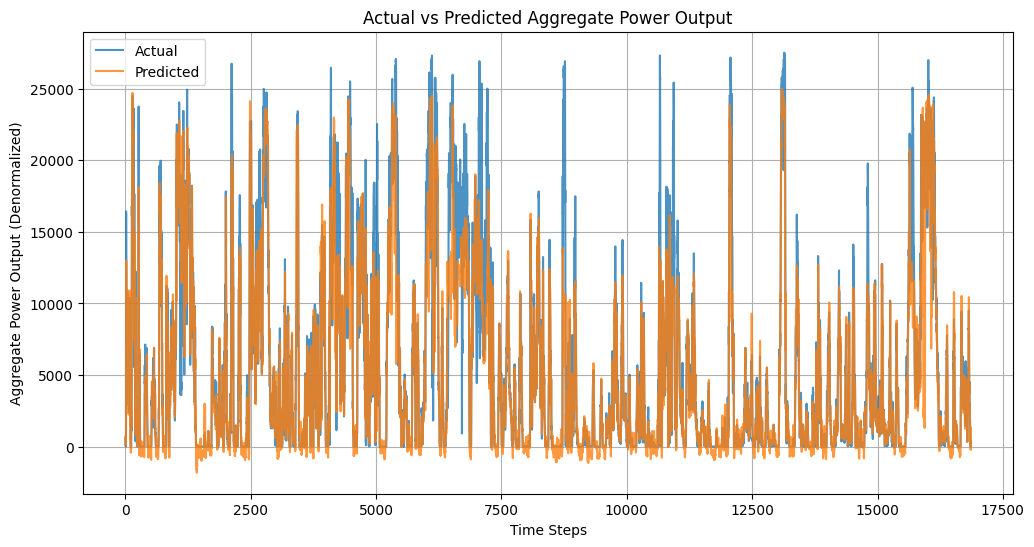

In [19]:
from sklearn.metrics import mean_absolute_error

# Make predictions
y_pred_normalized = model.predict(X_test)
y_pred = scaler_target.inverse_transform(y_pred_normalized)
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test_original, y_pred)
print(f"Final MAE: {mae}")

# Plot predictions vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual", alpha=0.8)
plt.plot(y_pred, label="Predicted", alpha=0.8)
plt.title("Actual vs Predicted Aggregate Power Output")
plt.xlabel("Time Steps")
plt.ylabel("Aggregate Power Output (Denormalized)")
plt.legend()
plt.grid()
plt.show()

### GCGNN

In [20]:
from sklearn.metrics import mean_absolute_error
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.nn import GRU
import networkx as nx
import matplotlib.pyplot as plt

In [21]:
df_turbines = pd.read_csv(TURBINE_LOC_PATH)
df_turbines = df_turbines[
    df_turbines["TurbID"].isin(
        [120, 121, 122, 95, 96, 110, 84, 85, 86, 16, 17, 18, 28, 29, 30, 65, 66, 67]
    )
]

In [22]:
df_turbines

,TurbID,x,y,Ele
15,16,3333.9042,1658.25733,1400.500000
16,17,3334.2558,2140.55426,1405.099976
17,18,3336.8477,2615.58831,1407.400024
27,28,4373.2043,7122.64010,1441.700073
28,29,4267.1024,7597.96708,1442.099976
29,30,4333.9194,8075.09406,1446.599976
64,65,5256.8079,3557.32759,1418.400024
65,66,5298.3107,4032.58132,1423.500000
66,67,5303.0059,4512.23649,1426.800049
83,84,1954.9133,2399.67753,1404.400024


In [23]:
# Load data
features_df = clean_data[
    clean_data["TurbID"].isin(
        [120, 121, 122, 95, 96, 110, 84, 85, 86, 16, 17, 18, 28, 29, 30, 65, 66, 67]
    )
]
features_df = features_df.groupby("TurbID").head(1000).reset_index(drop=True)
features_df.sort_values(by=["TurbID", "Tmstamp"], inplace=True)
coordinates_df = df_turbines

In [24]:
# Normalize distances
coordinates_df["coords"] = list(
    zip(coordinates_df["x"], coordinates_df["y"], coordinates_df["Ele"])
)
distances = []
edges = []
for i, coord1 in enumerate(coordinates_df["coords"]):
    for j, coord2 in enumerate(coordinates_df["coords"]):
        if i != j:
            dist = np.linalg.norm(np.array(coord1) - np.array(coord2))
            distances.append(dist)
            edges.append((i, j))

distances = np.array(distances)
distances = (distances - distances.min()) / (distances.max() - distances.min())
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_weights = torch.tensor(distances, dtype=torch.float)

In [25]:
# Group and scale features
node_features = features_df[
    ["TurbID", "Tmstamp", "Wspd", "Etmp", "Itmp", "Prtv", "RelH", "Patv"]
]
scaler = StandardScaler()
node_features[["Wspd", "Etmp", "Itmp", "Prtv", "RelH", "Patv"]] = scaler.fit_transform(
    node_features[["Wspd", "Etmp", "Itmp", "Prtv", "RelH", "Patv"]]
)

/var/folders/37/hnn7hl3j01z6rnvld0st0lg40000gn/T/ipykernel_41061/3520831951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_features[["Wspd", "Etmp", "Itmp", "Prtv", "RelH", "Patv"]] = scaler.fit_transform(


In [26]:
# Create input-output sequences
sequence_length = 12
forecast_horizon = 6
input_features = ["Wspd", "Etmp", "Itmp", "Prtv", "RelH", "Patv"]

input_scaler = StandardScaler()
target_scaler = StandardScaler()

node_features[input_features] = input_scaler.fit_transform(
    node_features[input_features]
)
node_features["Patv"] = target_scaler.fit_transform(node_features[["Patv"]])

/var/folders/37/hnn7hl3j01z6rnvld0st0lg40000gn/T/ipykernel_41061/2003798146.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_features[input_features] = input_scaler.fit_transform(
/var/folders/37/hnn7hl3j01z6rnvld0st0lg40000gn/T/ipykernel_41061/2003798146.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_features["Patv"] = target_scaler.fit_transform(node_features[["Patv"]])


In [27]:
# Create input-output sequences (fixed to avoid index reset)
def create_sequences(data, seq_length, forecast_horizon):
    inputs, targets = [], []
    for i in range(len(data) - seq_length - forecast_horizon):
        seq_x = data.iloc[i : i + seq_length][input_features].values
        seq_y = data.iloc[i + seq_length : i + seq_length + forecast_horizon][
            "Patv"
        ].sum()
        inputs.append(seq_x)
        targets.append(seq_y)
    return np.array(inputs), np.array(targets)


all_sequences = []
all_targets = []
for turbine_id, group in node_features.groupby("TurbID"):
    sequences, targets = create_sequences(group, sequence_length, forecast_horizon)
    all_sequences.append(sequences)
    all_targets.append(targets)

inputs = torch.tensor(np.concatenate(all_sequences), dtype=torch.float)
targets = torch.tensor(np.concatenate(all_targets), dtype=torch.float)

# Split data
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    inputs, targets, test_size=0.2, random_state=42
)

train_data = Data(
    x=train_inputs, edge_index=edges, edge_attr=edge_weights, y=train_targets
)
test_data = Data(
    x=test_inputs, edge_index=edges, edge_attr=edge_weights, y=test_targets
)

In [28]:
# Graph-based GRU model
class GraphTemporalModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_turbines):
        super(GraphTemporalModel, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.gru = GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        batch_size, seq_len, num_features = x.size()
        x = x.view(-1, num_features)
        x = self.gcn1(x, edge_index, edge_weight=edge_attr)
        x = torch.relu(x)
        x = self.gcn2(x, edge_index, edge_weight=edge_attr)
        x = x.view(batch_size, seq_len, -1)
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = x.view(batch_size, -1)
        return self.fc(x)

In [29]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = GraphTemporalModel(
    input_dim=len(input_features),
    hidden_dim=64,
    output_dim=1,
    num_turbines=coordinates_df.shape[0],
).to(device)

train_data = train_data.to(device)
test_data = test_data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

model.train()
for epoch in range(150):
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index, train_data.edge_attr)
    loss = criterion(out.squeeze(), train_data.y)
    loss.backward()
    optimizer.step()
    print("Epoch: {}, Loss: {}".format(epoch, loss.item()))

Epoch: 0, Loss: 33.78407669067383
Epoch: 1, Loss: 28.76703643798828
Epoch: 2, Loss: 21.56901741027832
Epoch: 3, Loss: 13.464343070983887
Epoch: 4, Loss: 9.733222961425781
Epoch: 5, Loss: 9.198535919189453
Epoch: 6, Loss: 9.432574272155762
Epoch: 7, Loss: 9.455527305603027
Epoch: 8, Loss: 9.27584171295166
Epoch: 9, Loss: 8.910027503967285
Epoch: 10, Loss: 8.332414627075195
Epoch: 11, Loss: 7.7324652671813965
Epoch: 12, Loss: 7.191582679748535
Epoch: 13, Loss: 6.749553203582764
Epoch: 14, Loss: 6.4400105476379395
Epoch: 15, Loss: 6.269799709320068
Epoch: 16, Loss: 6.146575927734375
Epoch: 17, Loss: 5.9592156410217285
Epoch: 18, Loss: 5.682370185852051
Epoch: 19, Loss: 5.340006351470947
Epoch: 20, Loss: 4.982769012451172
Epoch: 21, Loss: 4.646331310272217
Epoch: 22, Loss: 4.342913627624512
Epoch: 23, Loss: 4.071653842926025
Epoch: 24, Loss: 3.8143937587738037
Epoch: 25, Loss: 3.567110776901245
Epoch: 26, Loss: 3.3462886810302734
Epoch: 27, Loss: 3.1579909324645996
Epoch: 28, Loss: 3.02707

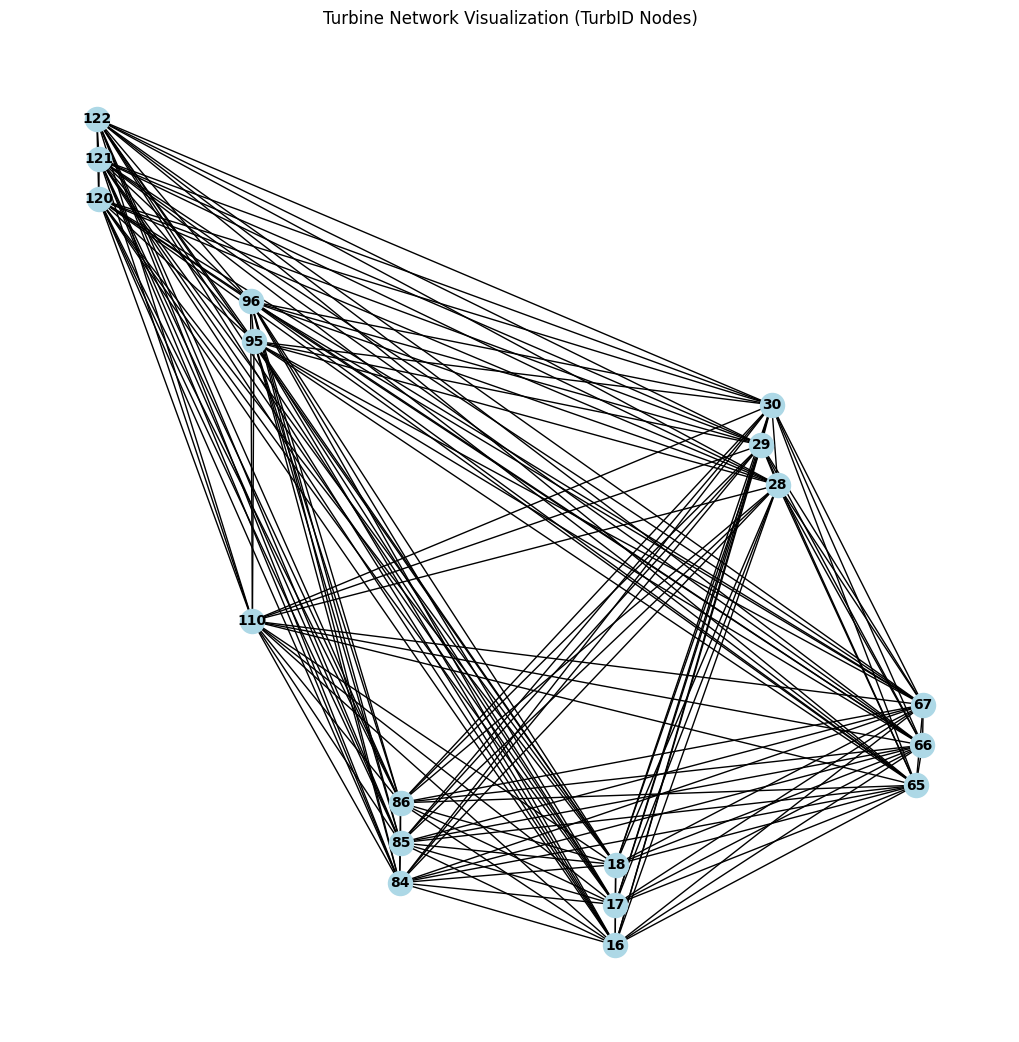

In [30]:
# Update graph visualization
G = nx.Graph()
for i, coord1 in coordinates_df.iterrows():
    for j, coord2 in coordinates_df.iterrows():
        if i != j:
            dist = np.linalg.norm(
                np.array(coord1[["x", "y", "Ele"]])
                - np.array(coord2[["x", "y", "Ele"]])
            )
            G.add_edge(coord1["TurbID"], coord2["TurbID"], weight=dist)

# Visualize the graph with TurbID
pos = {row["TurbID"]: (row["x"], row["y"]) for _, row in coordinates_df.iterrows()}
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=300,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
)
plt.title("Turbine Network Visualization (TurbID Nodes)")
plt.show()

In [31]:
# Evaluate and plot predictions
model.eval()
with torch.no_grad():
    predictions = (
        model(test_data.x, test_data.edge_index, test_data.edge_attr)
        .squeeze()
        .cpu()
        .numpy()
    )
    actuals = test_data.y.cpu().numpy()

# Denormalize using the target scaler
predictions_denorm = target_scaler.inverse_transform(
    predictions.reshape(-1, 1)
).flatten()
actuals_denorm = target_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

# Calculate and print MAE
# mae_denorm = np.mean(np.abs(predictions_denorm - actuals_denorm))
# print(f"Final De-normalized MAE: {mae_denorm}")

# Plot predictions vs actuals
# plt.figure(figsize=(10, 6))
# plt.plot(predictions_denorm, label="Predicted Power (kW)", alpha=0.7)
# plt.plot(actuals_denorm, label="Actual Power (kW)", alpha=0.7)
# plt.legend()
# plt.title("Predicted vs Actual Power Output (De-normalized)")
# plt.xlabel("Sample")
# plt.ylabel("Power (kW)")
# plt.show()